In [7]:
from inference3d import PathInference
from inference3d.helper import confidence_ellipse
from inference3d.kernel import kernelwrap, EQ
import numpy as np

Generate a synthetic example dataset

In [8]:
stationlocations = np.array([[3,3,0],[3,-3,0],[-3,3,0]])
obstimes = np.linspace(0,5,30)

observations = []
true_locations = []
for i,t in enumerate(obstimes):
    location = np.array([np.cos(np.pi*2*t/10)*10+10,np.sin(np.pi*2*t/10)*10,t/10])
    vect = location-stationlocations
    vect/= np.linalg.norm(vect,axis=1)[:,None]
    possibleobs = np.c_[stationlocations,vect]
    obs = possibleobs[i%3,:]
    observations.append(obs)
    true_locations.append(location)
observations = np.array(observations)
true_locations = np.array(true_locations)

Set up the path inference object:
- obstimes are the times we observed the tag
- observations are a series of [observer-location, vector-to-tag] rows
- EQ is our kernel
- likenoisescale - the standard deviation of our noise (e.g. in metres).

In [16]:
pathi = PathInference(obstimes, observations, kernelwrap(EQ,ls=5,scale=50), likenoisescale=0.2, Nind=7)

Run the inference. I've reduced the iterations to 500, and increased step size to 0.5 to run this demo notebook quickly.

In [17]:
pathi.run(500,0.5)

0 [20743.883]
20 [6529.3335]
40 [2448.0142]
60 [1640.7976]
80 [1208.1221]
100 [900.62994]
120 [656.4183]
140 [469.8913]
160 [331.73602]
180 [233.31337]
200 [166.66699]
220 [118.9389]
240 [89.20108]
260 [70.81763]
280 [57.042274]
300 [50.14933]
320 [46.80047]
340 [42.22795]
360 [39.845528]
380 [38.964813]
400 [38.115574]
420 [38.908974]
440 [38.268005]
460 [38.481407]
480 [37.803604]


Build an input test matrix, and compute the mean and covariance at each of these test points

In [18]:
Xtest = pathi.buildinputmatrix(100)
M,C = pathi.getpredictions(Xtest)

Plot the results

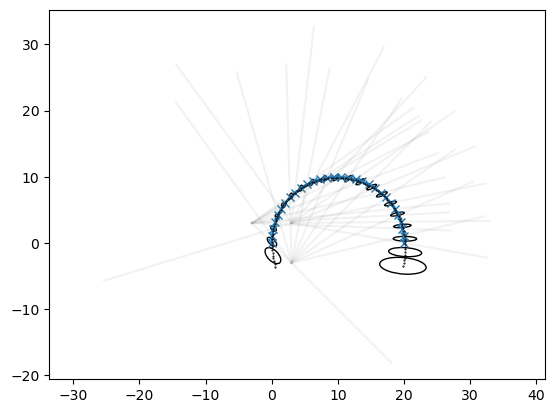

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis('equal')
plt.plot(true_locations[:,0],true_locations[:,1],'x-')
plt.axis('equal')
for obs in observations:
    plt.plot([obs[0],obs[0]+obs[3]*30],[obs[1],obs[1]+obs[4]*30],color='grey',alpha=0.1)

ax = plt.gca()
for i,(m,c) in enumerate(zip(M.numpy(),C.numpy())):
    std = max(np.sqrt(c[0,0]),np.sqrt(c[1,1]))
    plt.plot(m[0],m[1],'.k',markersize=1)

    if i%5==0:
        el = confidence_ellipse(m[:2],c[:2,:2],ax)
        ax.add_patch(el)

plt.show()

If lengthscale is reduced one can see we have a quick reversion back to the origin (due to the short lengthscale).